### Preprocessing data

Scripts needed to preprocess the data for instant visualization.

Process and normalize the data.
And also create Gaussian processes of each variable and save it in a single pickle file.


In [64]:
import pandas as pd
import numpy as np

# parameters and paths
FETA_data = "data/FETA_data.csv"

# list of relevant features
features = ["CSF", "GM", "WM", "LV", "CBM", "DGM", "BS"]


In [65]:
# read in data
df = pd.read_csv(FETA_data)

# Normalize it by folder
for folder in df["folder"].unique():
    for feature in features:
        df.loc[df["folder"] == folder, feature] = (
            df.loc[df["folder"] == folder, feature]
            - df.loc[df["folder"] == folder, feature].mean()
        ) / df.loc[df["folder"] == folder, feature].std()



In [148]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, DotProduct

models = {}

# Create a standard Gaussian process regression for each feature
for feature in features:
    # Select only rows where pathology == Neurotypical
    df_neuro = df[df["pathology"] == "Neurotypical"]
    
    # Define the kernel
    kernel = C(1.0, (0.1, 50.5)) * RBF(length_scale=50.0, length_scale_bounds=(5, 1e3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e+1))

    # Initialize Gaussian process regression model
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, normalize_y=False, random_state=0)
    
    # Fit the Gaussian process regression model
    gpr.fit(df_neuro[["age"]], df_neuro[feature])
    
    # Print the parameters
    print(gpr.kernel_)

    # Save the model in a dictionary
    models[feature] = gpr


1.74**2 * RBF(length_scale=15.1) + WhiteKernel(noise_level=0.291)
2.89**2 * RBF(length_scale=15.8) + WhiteKernel(noise_level=0.291)
1.87**2 * RBF(length_scale=12.7) + WhiteKernel(noise_level=0.191)
0.38**2 * RBF(length_scale=24.5) + WhiteKernel(noise_level=0.0425)
3.27**2 * RBF(length_scale=14.9) + WhiteKernel(noise_level=0.208)
1.33**2 * RBF(length_scale=10.1) + WhiteKernel(noise_level=0.431)
2.15**2 * RBF(length_scale=17.9) + WhiteKernel(noise_level=0.356)


/home/gerard/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


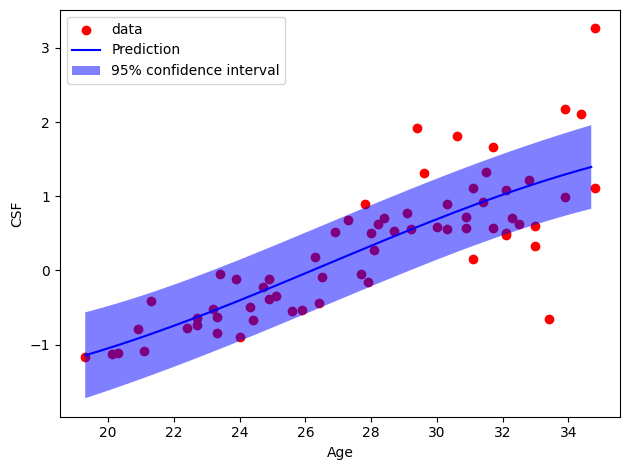

/home/gerard/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


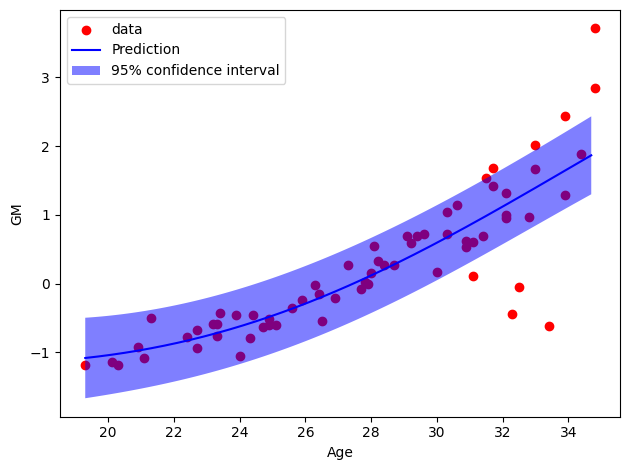

/home/gerard/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


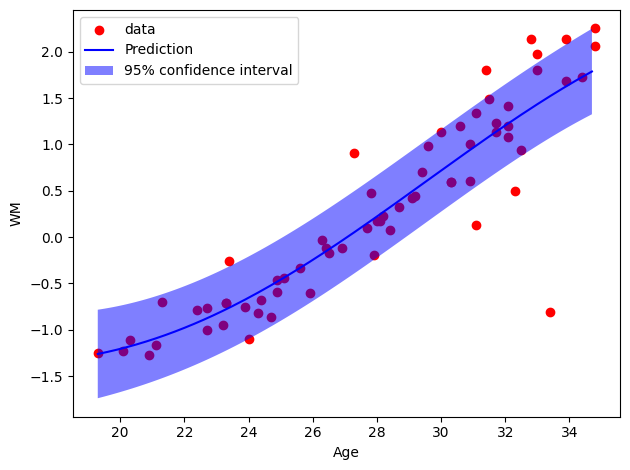

/home/gerard/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


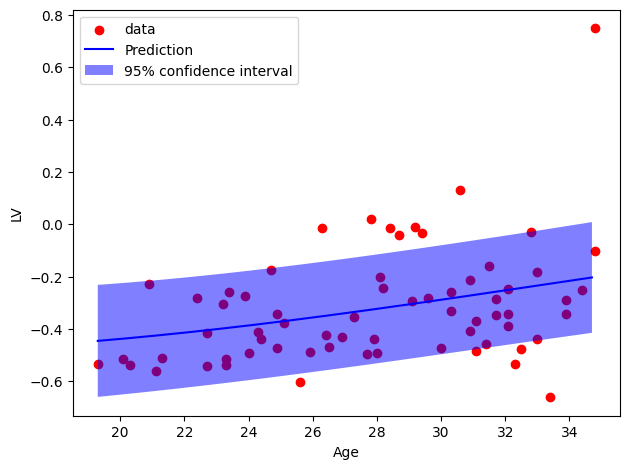

/home/gerard/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


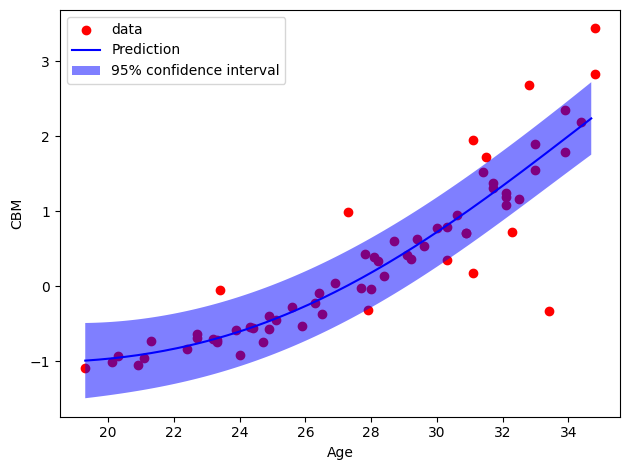

/home/gerard/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


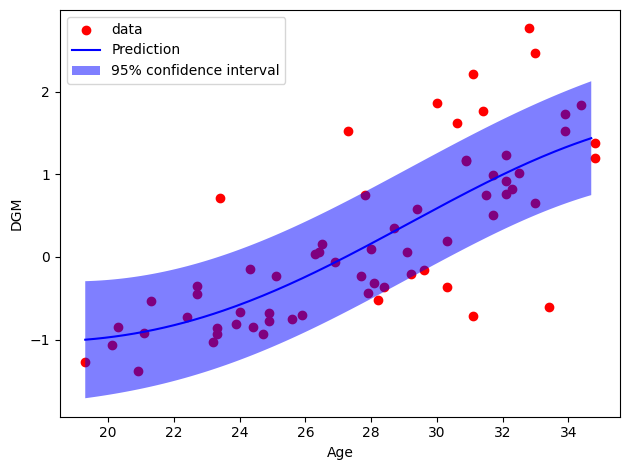

/home/gerard/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


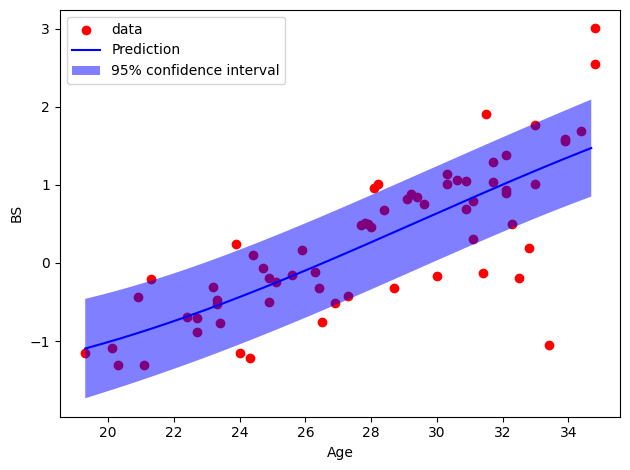

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the gaussian processes
for feature, model in models.items():
    # Define the range of the x-axis (age)

    # goes from the min and max age in the dataset, with a step of 0.1
    x = np.arange(df_neuro["age"].min(), df_neuro["age"].max(), 0.1)[:, np.newaxis]

    # Make the prediction on the entire range
    y_pred, sigma = model.predict(x, return_std=True)
    
    # Plot the function, the prediction and the 95% confidence interval
    plt.figure()
    plt.scatter(df_neuro["age"], df_neuro[feature], c='r', label='data')
    plt.plot(x, y_pred, 'b', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - sigma,
                             (y_pred + sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', in_layout=False, label='95% confidence interval')
    plt.xlabel('Age')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [55]:
import pickle

# Save the models dictionary as a pickle
with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

# Save the normalized dataframe as a csv
df.to_csv('data/FETA_normalized_data.csv', index=False)
